In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, MaxPooling2D, Dense, Conv2D, AveragePooling2D, BatchNormalization, Dropout, Activation, Input, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [5]:
x_train = (x_train / 255).astype('float32')
x_test = (x_test / 255).astype('float32')

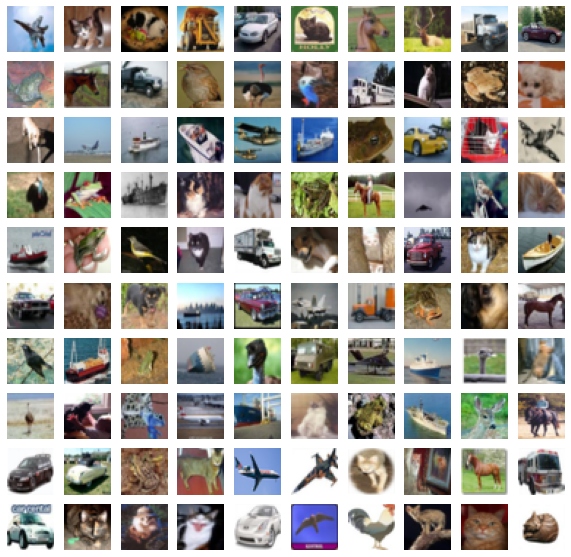

In [6]:
numClasses = np.unique(y_train).shape[0]

fig, axe = plt.subplots(numClasses, numClasses, figsize=(10, 10))

for i in range (numClasses):
  for j in range (numClasses):
    k = np.random.choice(range(len(x_train)))
    axe[i][j].imshow(x_train[k])
    axe[i][j].set_axis_off()

In [7]:
def lr_shedule(epoch):
  """
  epoch: number of epochs

  return learning rate
  """
  lr = 0.001
  if epoch > 20:
    return 0.0001
  elif epoch > 15:
    return 0.0005
  elif epoch > 10:
    return 0.0008
  return lr

In [8]:
def residual_block(inputs, downsample, number_filters):
  y = Conv2D(number_filters,
             (3,3),
             strides=(1 if not downsample else 2),
             padding='same',
             kernel_regularizer=l2(0.001))(inputs)
  y = Activation('relu')(y)
  y = BatchNormalization()(y)

  y = Conv2D(number_filters,
             (3,3),
             strides=1,
             padding='same',
             kernel_regularizer=l2(0.001))(y)

  if downsample:
    inputs = Conv2D(number_filters,
                    (1,1),
                    strides=2,
                    padding='same',
                    kernel_regularizer=l2(0.001))(inputs)
    
  outputs = Add()([inputs, y])
  outputs = BatchNormalization()(outputs)
  outputs = Activation('relu')(outputs)

  return outputs

In [9]:
def res_net():

  inputs = Input((32,32,3))
  num_filters = 32

  y = Conv2D(num_filters,
                (3,3),
                strides=1,
                padding='same')(inputs)
  y = BatchNormalization()(y)
  y = Activation('relu')(y)

  ''''
  model = Sequential()
  model.add(Conv2D(.., input_shape=(32, 32, 3)))
  model.add(BatchNorm...)
  model.add(Activation)
  '''

  num_blocks_list = [2, 3, 3, 2]

  for i in range(len(num_blocks_list)):
    num_blocks = num_blocks_list[i]
    for j in range (num_blocks):
      y = residual_block(y, downsample=(j==0 and i!=0), number_filters=num_filters)
    num_filters *= 2

  y = AveragePooling2D(4)(y)
  y = Flatten()(y)
  y = Dense(512, activation='relu')(y)
  y = Dropout(0.4)(y)
  outputs = Dense(10, activation='softmax')(y)

  model = Model(inputs, outputs)

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  
  return model


In [10]:
model = res_net()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [12]:
hist = model.fit(x_train, y_train,
                 epochs=25,
                 batch_size=256,
                 callbacks=[LearningRateScheduler(lr_shedule)],
                 validation_data=(x_test,y_test),
                 verbose=1)

Epoch 1/25
196/196 [==============================] - 19s 98ms/step - loss: 3.2415 - accuracy: 0.4331 - val_loss: 4.5124 - val_accuracy: 0.1000
Epoch 2/25
196/196 [==============================] - 19s 95ms/step - loss: 1.9738 - accuracy: 0.6131 - val_loss: 2.6533 - val_accuracy: 0.3848
Epoch 3/25
196/196 [==============================] - 19s 96ms/step - loss: 1.5175 - accuracy: 0.7010 - val_loss: 2.4156 - val_accuracy: 0.4319
Epoch 4/25
196/196 [==============================] - 19s 98ms/step - loss: 1.3036 - accuracy: 0.7490 - val_loss: 1.4511 - val_accuracy: 0.6979
Epoch 5/25
196/196 [==============================] - 19s 99ms/step - loss: 1.1623 - accuracy: 0.7788 - val_loss: 1.3660 - val_accuracy: 0.6928
Epoch 6/25
196/196 [==============================] - 19s 99ms/step - loss: 1.0619 - accuracy: 0.8036 - val_loss: 1.3082 - val_accuracy: 0.7088
Epoch 7/25
196/196 [==============================] - 19s 99ms/step - loss: 0.9956 - accuracy: 0.8225 - val_loss: 1.2525 - val_accuracy:

In [16]:
hist.history['accuracy']

[0.43314000964164734,
 0.6131399869918823,
 0.700980007648468,
 0.7490000128746033,
 0.7787600159645081,
 0.8035600185394287,
 0.8224999904632568,
 0.8347200155258179,
 0.844539999961853,
 0.8582599759101868,
 0.8623200058937073,
 0.8896600008010864,
 0.8977400064468384,
 0.9046400189399719,
 0.9113199710845947,
 0.9151399731636047,
 0.9509599804878235,
 0.958079993724823,
 0.9602199792861938,
 0.9595000147819519,
 0.9589599967002869,
 0.9879599809646606,
 0.9986400008201599,
 0.9997199773788452,
 0.9995999932289124]